In [4]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import psycopg2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#this line causes errors when running as a .py script
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 40
#pd.options.display.max_colwidth = 200
pd.options.display.show_dimensions = True

def connect():
    #parameter format for local use
    params = {
    'dbname':'hmda',
    'user':'roellk',
    'password':'',
    'host':'localhost',}
    #connect_string = "dbname=%s user=%s host=%s password =%s" %(dbname, user, host, password) #set a string for connection to SQL
    try:
        conn = psycopg2.connect(**params)
        print("i'm connected")
        #return conn.cursor(cursor_factory=psycopg2.extras.DictCursor) #return a dictionary cursor object
        return conn.cursor()
    except psycopg2.Error as e: #if database connection results in an error print the following
        print("I am unable to connect to the database: ", e)

def line_graph(field_df, title=None, size=(20,10), ylim=None, x=np.arange(2004,2017)):
    """size is a tuple of width x height, ylim is a tuple of min x max"""
    plt.figure(figsize=size)
    color_list = ["purple", "blue", "orange", "yellow", "green", "grey", "black", "white", "red"]
    field_list = list(field_df.columns.ravel())
    patch_list = []
#    w_patch = mpatches.Patch(color="green", label="white")
    for field in field_list:
        color_index = field_list.index(field)
        plt.plot(x, field_df[field], color=color_list[color_index]) 
        field_patch = mpatches.Patch(color=color_list[color_index], label=field)
        patch_list.append(field_patch)
    if ylim:
        plt.ylim=ylim
    plt.legend(handles=patch_list)
    plt.title(title)

        
def tabular_lines(y_dict, title=None, size=(20,10), ylim=None, x=np.arange(2004,2017)):
    plt.figure(figsize=size)
    color_list = ["purple", "blue", "orange", "yellow", "green", "grey", "black", "white", "red"]
    if ylim:
        plt.ylim = ylim
    patch_list = []
    y_list = list(y_dict.keys())
    for field in y_list:
        color_index = y_list.index(field)
        plt.plot(x, y_dict[field], color=color_list[color_index])
        field_patch = mpatches.Patch(color=color_list[color_index], label=field)
        patch_list.append(field_patch)
    plt.legend(handles=patch_list)
    plt.title(title)

In [5]:
#this code will examine the incidence of higher cost loans on manufactured housing in historic HMDA LAR data.
#Higher cost loans for manufactured housing are defined as:
#A first lien on a loan with >=50K principal with a rate spread of 6.5% or more
#A first lien on a loan with <50K principal with a rate spread of 8.5% or more
#A junior lien with a rate spread of 8.5% or more
#Note: high cost loans are only covered by HOEPA if on a principle residence
#Note: rate spread in HMDA has had different benchmarks
# - rate spread prior to 2010 was calculated using treasury 10 year notes
# - rate spread 2010 and later is calculated using APOR tables 
#Note: the change was made in 4q 2009, so 2009 uses mixed data in rate spread calculations and is often
#excluded from analysis
#Note: rate spread analysis is commonly done only on originations

In [11]:
#load rate spread data file for analysis
rs_df = pd.read_csv("../output/base_data.csv", sep="|", dtype="object")

In [12]:
#change data types for mathematics
rs_df.loan_amount = rs_df.loan_amount.apply(lambda x: int(x))
rs_df.rate_spread = rs_df.rate_spread.apply(lambda x: float(x))
#set high priced flag for rate spreads that meet conditions
def is_high_priced(row):
    if row['lien_status']=='1' and row['loan_amount'] >=50 and row['rate_spread'] >= 6.5:
        return 1
    elif row['lien_status']=='1' and row['loan_amount'] <50 and row['rate_spread']>=8.5:
        return 1
    elif row['lien_status']=='2' and row['rate_spread']>=8.5:
        return 1
    else:
        return 0
    
rs_df['high_priced'] = rs_df.apply(is_high_priced, axis=1)


In [14]:
#get amount summed by year for high priced and normal loans
#multi index set for high priced flag and year
def calc_rs_stats(rs_df):
    print("flagging historic data")
    amount_df = rs_df[['year', 'high_priced', 'loan_amount']].groupby(['high_priced', 'year']).sum().copy()
    total_high_rows = rs_df[rs_df.high_priced==1].groupby('year').count().copy()
    total_rows = rs_df.groupby('year').count().copy()
    analysis_df = total_high_rows / total_rows
    analysis_df = analysis_df[['hoepa']]
    analysis_df.columns = ['high_priced_pct']
    analysis_df['count_high'] = total_high_rows['rate_spread']
    analysis_df['count_total'] = rs_df[['year','rate_spread']].groupby('year').count()
    analysis_df['count_normal'] = analysis_df['count_total'] - analysis_df['count_high']
    analysis_df['percent_normal'] = 1 - analysis_df['high_priced_pct']
    analysis_df['amount_high'] = amount_df['loan_amount'].loc[1]
    analysis_df['amount_normal'] = amount_df['loan_amount'].loc[0]
    analysis_df['amount_total'] = analysis_df['amount_high'] + analysis_df['amount_normal']
    analysis_df['amount_high_pct'] = analysis_df.apply(lambda x: x.amount_high/x.amount_total, axis=1)
    analysis_df['amount_normal_pct'] = analysis_df.apply(lambda x: x.amount_normal/x.amount_total, axis=1)
    return analysis_df

#all data is for manufactured housing, purchase or refinance loans, owner occupied
all_loans = calc_rs_stats(rs_df)

#home purchase loans <50k amount
purch_less_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='1')&(rs_df.loan_amount<50)])
#home purchase loans>=50k amount
purch_over_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='1')&(rs_df.loan_amount>=50)])

#no refinances <50k amount present
#refi_less_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='3')&(rs_df.loan_amount<50)])
#refinance loans >=50k amount
refi_over_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='3')&(rs_df.loan_amount>=50)])

#first lien loans <50k amount
lien_1 = calc_rs_stats(rs_df[(rs_df.lien_status=='1')&(rs_df.loan_amount<50)])
#junior lien loans >=50k amount
lien_2 = calc_rs_stats(rs_df[(rs_df.lien_status=='1')&(rs_df.loan_amount>=50)])

#all loans <50k
all_less_50 = calc_rs_stats(rs_df[(rs_df.loan_amount<50)])
#all loans >=50k
all_over_50 = calc_rs_stats(rs_df[(rs_df.loan_amount>=50)])

#total incidence trend as percent
#total incidence raw counts
#trend for over 50k and under 50k separately (percents and counts)
#analysis by purpose?
#analysis by lien status
#baseline against trend in single family homes?
#by geography
#get drop from 2013 to 2014 (dollar, percentage of loans, average rate)


Getting historic data
Getting historic data
Getting historic data
Getting historic data
Getting historic data
Getting historic data
Getting historic data
Getting historic data


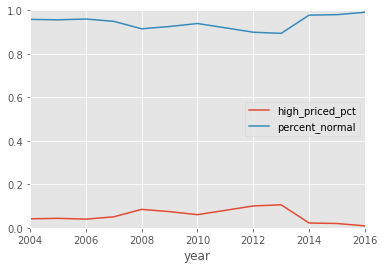

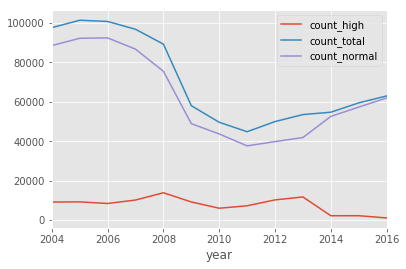

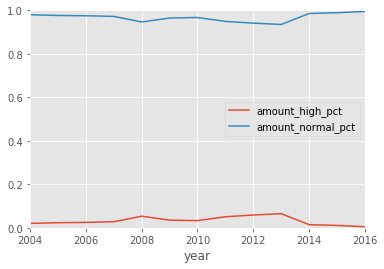

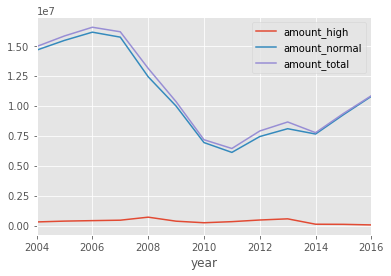

In [16]:
#examine all loans
#check percentage of high priced vs normal
all_loans[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
all_loans[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
all_loans[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
all_loans[['amount_high', 'amount_normal', 'amount_total']].plot()

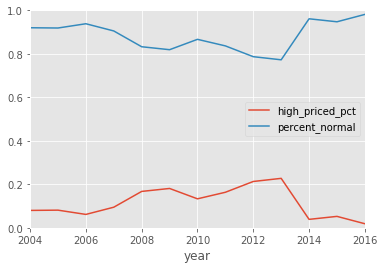

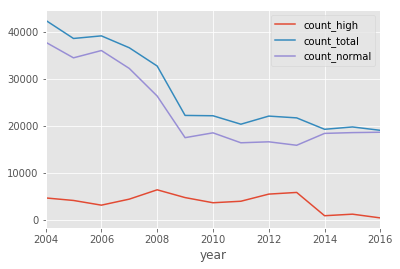

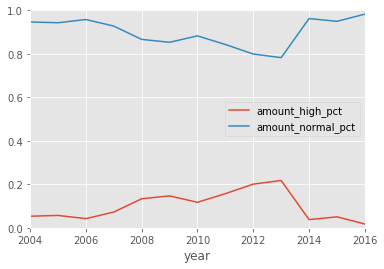

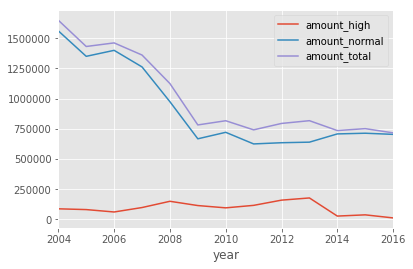

In [17]:
#home purchase loans <50k amount
#check percentage of high priced vs normal
purch_less_50[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
purch_less_50[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
purch_less_50[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
purch_less_50[['amount_high', 'amount_normal', 'amount_total']].plot()

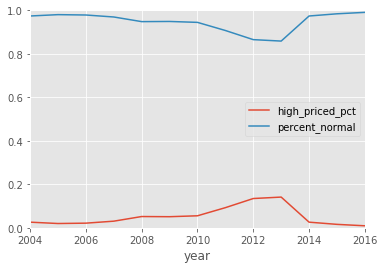

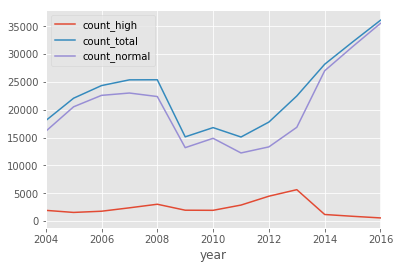

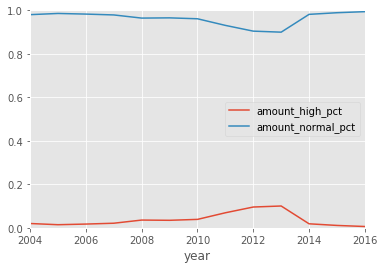

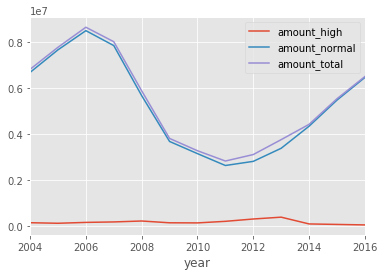

In [18]:
#home purchase loans >=50k amount
#check percentage of high priced vs normal
purch_over_50[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
purch_over_50[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
purch_over_50[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
purch_over_50[['amount_high', 'amount_normal', 'amount_total']].plot()

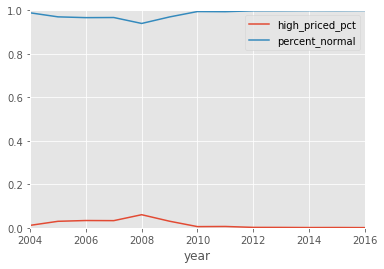

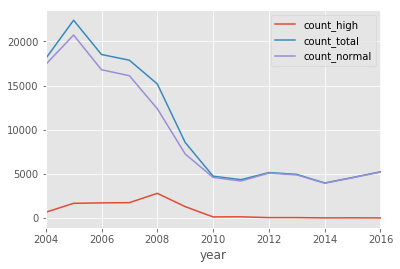

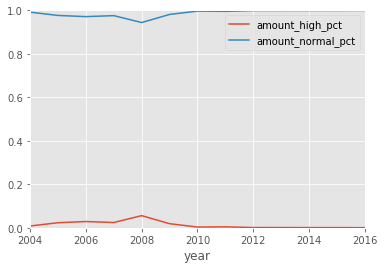

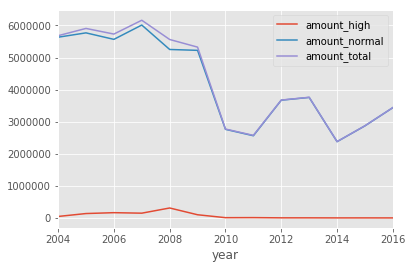

In [19]:
#refi loans >=50k amount
#check percentage of high priced vs normal
refi_over_50[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
refi_over_50[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
refi_over_50[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
refi_over_50[['amount_high', 'amount_normal', 'amount_total']].plot()

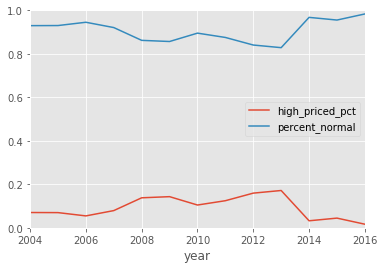

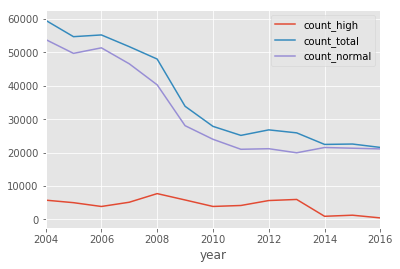

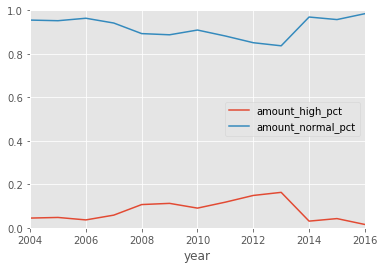

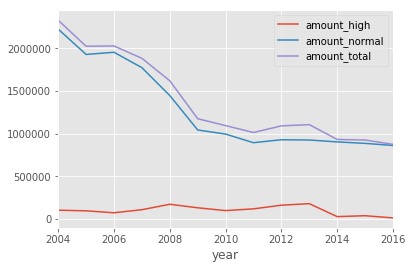

In [20]:
#first lien loans <50k amount
#check percentage of high priced vs normal
lien_1[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
lien_1[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
lien_1[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
lien_1[['amount_high', 'amount_normal', 'amount_total']].plot()

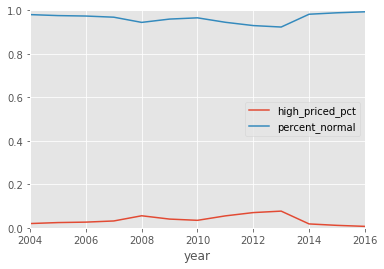

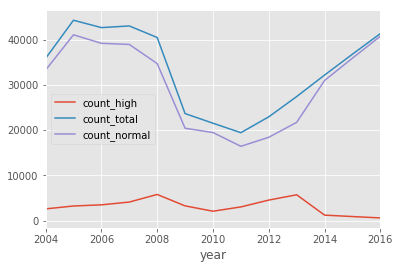

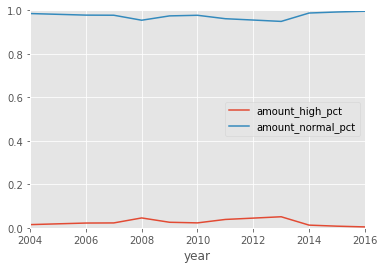

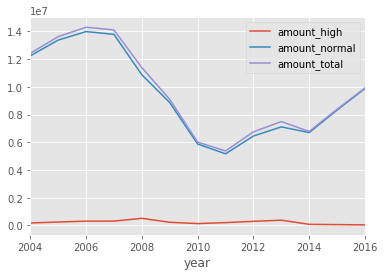

In [22]:
#junior lien loans >=50k amount
#check percentage of high priced vs normal
lien_2[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
lien_2[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
lien_2[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
lien_2[['amount_high', 'amount_normal', 'amount_total']].plot()

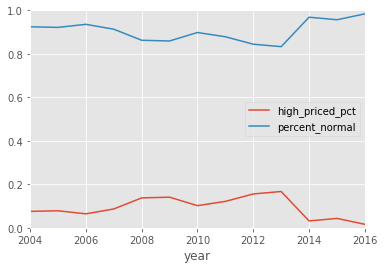

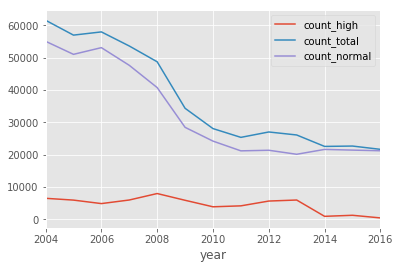

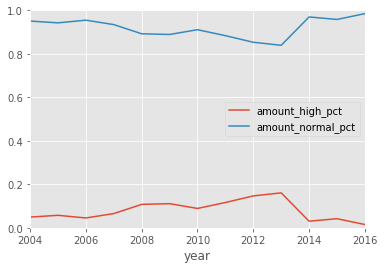

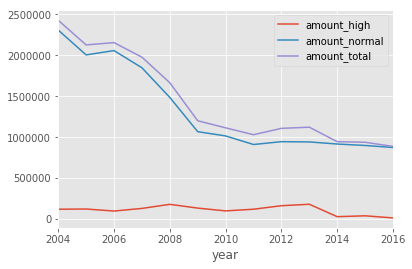

In [23]:

#all loans <50k
all_less_50[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
all_less_50[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
all_less_50[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
all_less_50[['amount_high', 'amount_normal', 'amount_total']].plot()

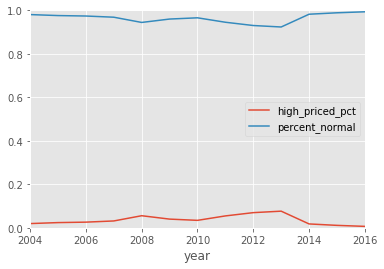

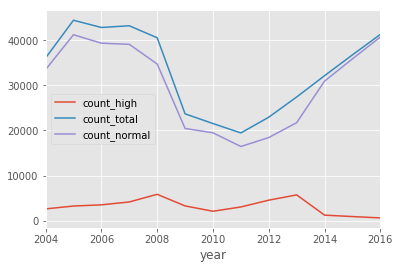

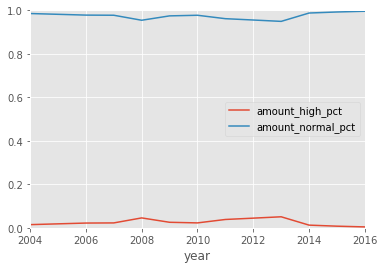

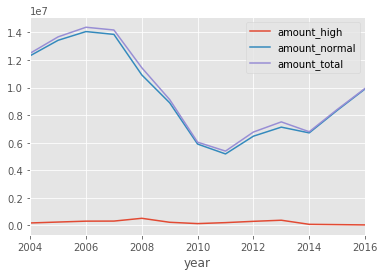

In [24]:

#all loans >=50k
all_over_50[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))
#check count of high-priced, normal, and total loans in sample
all_over_50[['count_high', 'count_total', 'count_normal']].plot()
#check dollar percentage distribution of amount between high-priced vs normal loans
all_over_50[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))
#check actual amount distribution between high priced and normal loans
all_over_50[['amount_high', 'amount_normal', 'amount_total']].plot()